In [1]:
import datetime
now = datetime.datetime.now()


In [2]:
%pip install lightning --quiet
%pip install kaggle --quiet

In [3]:
import os
from google.colab import userdata
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')

In [4]:
import os

os.system("kaggle competitions download -c gan-getting-started")
os.system("unzip -nq gan-getting-started.zip")

0

# The Problem
This Kaggle competition ask for a model that can generate monet style outputs given photographs.

# The Data
The dataset includes 300 monet paintings in 256x256x3 JPEG format and ~7000 photos in the same format.

# The Model
My model is based on CCGAN. The approach extends typical GAN architecture by training a set of models that are cycle consistent. This means the model can convert from one domain to another and then back again with low loss. These two generators are paired with discriminators as in the original GAN architecture. The end result is a model that can do the desired conversion, but also the inverse. The benefit of this is described in the paper below. In short, by being cycle consistent, the system performs better than other architectures.

Below is the reference paper for the CCGAN architecture.

Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks

Jun-Yan Zhu, Taesung Park, Phillip Isola, Alexei A. Efros

https://arxiv.org/abs/1703.10593

Other models include a pure GAN approach with CNN for the generator and discriminator. This gives poor results and is difficult to train.

## Generator Details

My generator model has a downconverter stage followed by residual layers and finally an upconversion stage. This is similar to the CCGAN model from the paper, but somewhat simpler.

## Transformations
As an image task, transformations provided by torchvision are useful to improve training. Resizing, random cropping, random rotations, and normalization are all used.

I tried a variety of transformations before settling on the current implementation.

## Normalization Layers
Batch Normalization is the typical starting point for most models needing normalization, but most sources online suggest using Instance Normalizationa according to this 2017 paper.

Instance Normalization: The Missing Ingredient for Fast Stylization

Dmitry Ulyanov, Andrea Vedaldi, Victor Lempitsky

https://arxiv.org/abs/1607.08022

## Hyperparameter Tuning
I spent time optimizing the learning rate and even implemented a learning rate scheduler to improve performance. It is important to keep the loss of the discriminant from falling much quicker than the loss of the generator. As such, I set the learning rate of the generator 10x higher than the discriminator. The learning rate scheduler helps to slow the learning rate and close the gap in learning rate as the training reaches its end.

Batch size is an important consideration. I did not attempt very small batch sizes, but did see some discussion that lower batch sizes can improve model performance.



In [5]:
monet_path = "monet_jpg"
photo_path = "photo_jpg"

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import lightning as L

# suggested by the debug output, set precission medium or high
torch.set_float32_matmul_precision('medium')

class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, monet_transform=None, photo_transform=None):
        self.monet_images = [os.path.join(monet_dir, f) for f in os.listdir(monet_dir)]
        self.photo_images = [os.path.join(photo_dir, f) for f in os.listdir(photo_dir)]
        self.monet_transform = monet_transform
        self.photo_transform = photo_transform

    def __len__(self):
        return max(len(self.monet_images), len(self.photo_images))

    def __getitem__(self, idx):
        monet_img = Image.open(self.monet_images[idx % len(self.monet_images)]).convert("RGB")
        photo_img = Image.open(self.photo_images[idx % len(self.photo_images)]).convert("RGB")

        if self.monet_transform:
          monet_img = self.monet_transform(monet_img)

        if self.photo_transform:
          photo_img = self.photo_transform(photo_img)

        return monet_img, photo_img

transform_monet = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_photo = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = ImageDataset(monet_path, photo_path, monet_transform=transform_monet, photo_transform=transform_photo)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)


In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, inplace_relu=False):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=inplace_relu),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)  # Add skip connection


# Hyperparameters to consider
INPLACE_RELU = False # according to some sources inplace RELU can cause issues

class GeneratorWithRes(nn.Module):
    def __init__(self, num_residual_blocks=6, inplace_relu=False):
        super(GeneratorWithRes, self).__init__()

        # Downsampling layers
        self.downsampling = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=inplace_relu),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=inplace_relu),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=inplace_relu),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU(inplace=inplace_relu)
        )

        # Residual blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(512, inplace_relu=inplace_relu) for _ in range(num_residual_blocks)]
        )

        # Upsampling layers
        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=inplace_relu),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=inplace_relu),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=inplace_relu),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.downsampling(x)
        x = self.residual_blocks(x)
        x = nn.Dropout2d(0.5)(x)
        x = self.upsampling(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=INPLACE_RELU),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=INPLACE_RELU),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=INPLACE_RELU),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=INPLACE_RELU),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=INPLACE_RELU),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=INPLACE_RELU),
            nn.Dropout(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(128),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=INPLACE_RELU),
            nn.Dropout(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(256),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=INPLACE_RELU),
            nn.Dropout(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            # nn.BatchNorm2d(512),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=INPLACE_RELU),
            nn.Dropout(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
        )

    def forward(self, x):
        return self.main(x)

class CycleGAN(L.LightningModule):
    def __init__(self):
        super(CycleGAN, self).__init__()
        self.gen_monet = GeneratorWithRes()
        self.gen_photo = GeneratorWithRes()
        self.disc_monet = Discriminator()
        self.disc_photo = Discriminator()

        self.adversarial_loss = nn.MSELoss()
        self.cycle_loss = nn.L1Loss()
        self.identity_loss = nn.L1Loss()

        self.automatic_optimization = False

        # initial LR
        self.discriminator_init_lr = 0.001
        self.generator_init_lr = 0.01


    def forward(self, x):
        return self.gen_monet(x)

    def training_step(self, batch, batch_idx):
        monet_img, photo_img = batch
        opt_gen, opt_disc = self.optimizers()

        # Monet Generator (Photo -> Monet)
        fake_monet = self.gen_monet(photo_img)
        recon_photo = self.gen_photo(fake_monet)

        # Photo Generator (Monet -> Photo)
        fake_photo = self.gen_photo(monet_img)
        recon_monet = self.gen_monet(fake_photo)

        # GAN Loss
        loss_gan_monet = self.adversarial_loss(self.disc_monet(fake_monet), torch.ones_like(self.disc_monet(fake_monet)))
        loss_gan_photo = self.adversarial_loss(self.disc_photo(fake_photo), torch.ones_like(self.disc_photo(fake_photo)))

        # Cycle Consistency Loss
        loss_cycle_photo = self.cycle_loss(recon_photo, photo_img)
        loss_cycle_monet = self.cycle_loss(recon_monet, monet_img)

        # Identity Loss
        loss_identity_photo = self.identity_loss(self.gen_photo(photo_img), photo_img)
        loss_identity_monet = self.identity_loss(self.gen_monet(monet_img), monet_img)

        # Total Generator Loss
        loss_gen = (
            loss_gan_monet + loss_gan_photo +
            10.0 * (loss_cycle_photo + loss_cycle_monet) +
            5.0 * (loss_identity_photo + loss_identity_monet)
        )

        self.log("gen_loss", loss_gen, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        opt_gen.zero_grad()
        self.manual_backward(loss_gen)
        opt_gen.step()
        # log learning rate
        self.log("gen_lr", opt_gen.param_groups[0]['lr'], on_step=True, on_epoch=True, prog_bar=True, logger=True)

        # Discriminator Monet
        real_loss_monet = self.adversarial_loss(self.disc_monet(monet_img), torch.ones_like(self.disc_monet(monet_img)))
        fake_loss_monet = self.adversarial_loss(self.disc_monet(fake_monet.detach()), torch.zeros_like(self.disc_monet(fake_monet)))
        loss_disc_monet = (real_loss_monet + fake_loss_monet) / 2

        # Discriminator Photo
        real_loss_photo = self.adversarial_loss(self.disc_photo(photo_img), torch.ones_like(self.disc_photo(photo_img)))
        fake_loss_photo = self.adversarial_loss(self.disc_photo(fake_photo.detach()), torch.zeros_like(self.disc_photo(fake_photo)))
        loss_disc_photo = (real_loss_photo + fake_loss_photo) / 2

        # Total Discriminator Loss
        loss_disc = (loss_disc_monet + loss_disc_photo) / 2

        self.log("disc_loss", loss_disc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        opt_disc.zero_grad()
        self.manual_backward(loss_disc)
        opt_disc.step()
        # log learning rate
        self.log("disc_lr", opt_disc.param_groups[0]['lr'], on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def on_train_epoch_end(self):
        # step the scheduler on epochs
        scheduler_gen, scheduler_disc = self.lr_schedulers()
        scheduler_gen.step()
        scheduler_disc.step()

    def configure_optimizers(self):
        opt_gen = torch.optim.Adam(
            list(self.gen_monet.parameters()) + list(self.gen_photo.parameters()), lr=self.generator_init_lr, betas=(0.5, 0.999)
        )
        opt_disc = torch.optim.Adam(
            list(self.disc_monet.parameters()) + list(self.disc_photo.parameters()), lr=self.discriminator_init_lr, betas=(0.5, 0.999)
        )

        gen_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt_gen, gamma=0.8)
        disc_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt_disc, gamma=0.8)
        return [opt_gen, opt_disc], [gen_scheduler, disc_scheduler]

# Trainer Example
trainer = L.Trainer(max_epochs=5, log_every_n_steps=10, )
model = CycleGAN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


trainer.fit(model, dataloader)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | gen_monet        | GeneratorWithRes | 33.8 M | train
1 | gen_photo        | GeneratorWithRes | 33.8 M | train
2 | disc_monet       | Discriminator    | 2.8 M  | train
3 | disc_photo       | Discriminator    | 2.8 M  | train
4 | adversarial_loss | MSELoss          | 0      | train
5 | cycle_loss       | L1Loss           | 0      | train
6 | identity_loss    

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [12]:
class PhotoDataset(Dataset):
    def __init__(self, photo_dir, photo_transform=None):
      self.photo_images = [os.path.join(photo_dir, f) for f in os.listdir(photo_dir)]
      self.photo_transform = photo_transform

    def __len__(self):
        return len(self.photo_images)

    def __getitem__(self, idx):
        photo_img = Image.open(self.photo_images[idx % len(self.photo_images)]).convert("RGB")

        if self.photo_transform:
          photo_img = self.photo_transform(photo_img)

        return photo_img

transform_photo = transforms.Compose([
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

inference_dataset = PhotoDataset(photo_path, photo_transform=transform_photo)
inference_dataloader = DataLoader(inference_dataset, batch_size=1, shuffle=False)


torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


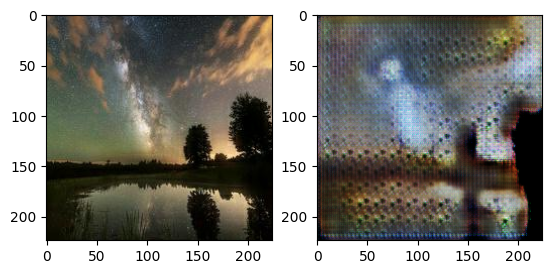

38dc8100e283a8bc314134d0480dce9c886f04f2b64931103fa540bf8b0abe9f
e420f3a184743bc66945555651f06da34d845d6079d682b7244bc8d4bc53d34f


In [13]:
# debugging
device = "cpu"

photo_img = next(iter(inference_dataloader)).to(device)  # Get one batch of photo images
with torch.no_grad():
    fake_monet = model.gen_monet(photo_img)
print(fake_monet.shape)  # Inspect the output shape
print(photo_img.shape)

# to RGB
fake_monet = (fake_monet + 1) / 2  # Normalize to [0, 1]
photo_img = (photo_img + 1) / 2

# display
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)
axes[0].imshow(photo_img[0].permute(1, 2, 0).cpu())
axes[1].imshow(fake_monet[0].permute(1, 2, 0).cpu())
plt.show()

# debugging
# I was getting output that matched my input at one stage of developing.
# This hashing check allowed me to confirm that my model was at least
# doing something
import hashlib

def hash_tensor(tensor):
    tensor_bytes = tensor.cpu().numpy().tobytes()
    return hashlib.sha256(tensor_bytes).hexdigest()

print(hash_tensor(fake_monet))
print(hash_tensor(photo_img))


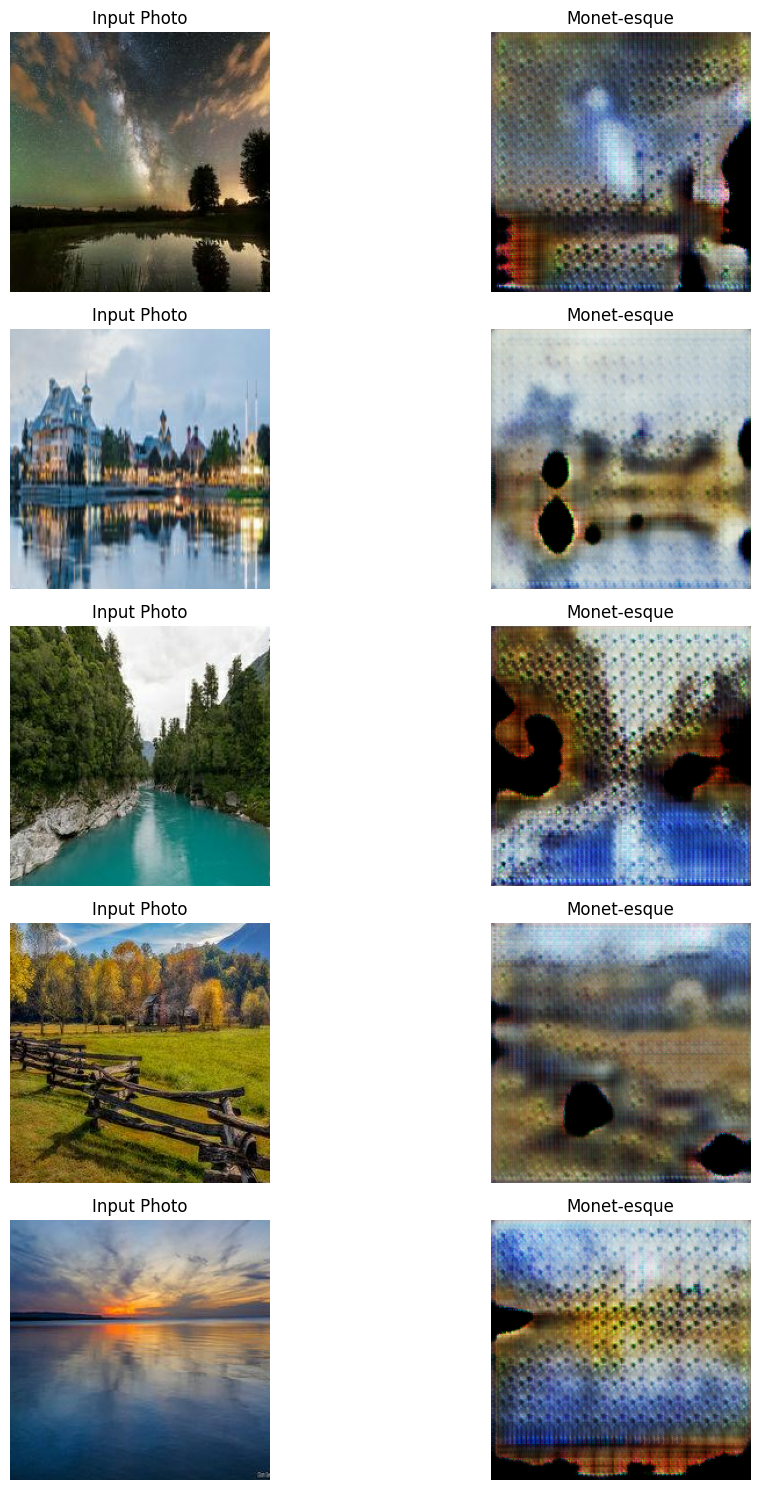

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(generator, photo_dir, device, num_images=5):

    _, ax = plt.subplots(num_images, 2, figsize=(12, num_images * 3))
    generator.to(device)
    generator.eval()  # Set the generator to evaluation mode

    for i in range(num_images):
        photo_images = [os.path.join(photo_dir, f) for f in os.listdir(photo_dir)]
        photo_img = Image.open(photo_images[i]).convert("RGB")

        photo_img = transform_photo(photo_img).unsqueeze(0).to(device)

        # Generate Monet-style images
        with torch.no_grad():
            fake_monet = generator(photo_img)

        photo_img = photo_img.detach()
        photo_img = photo_img.cpu()
        fake_monet = fake_monet.detach()
        fake_monet = fake_monet.cpu()

        # Convert tensors to numpy arrays
        photo_img = (photo_img[0].permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255
        fake_monet = (fake_monet[0].permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255

        # Display images
        ax[i, 0].imshow(photo_img.astype(np.uint8))
        ax[i, 1].imshow(fake_monet.astype(np.uint8))
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-esque")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

visualize_results(model.gen_monet, photo_path, device)

device =torch.device("cuda" if torch.cuda.is_available() else "cpu")

# save the monet style images
def save_monet_images(generator, dataloader, device, save_dir="output"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    generator.eval()  # Set the generator to evaluation mode

    for i, photo_img in enumerate(dataloader):

        # Move images to the device
        photo_img = photo_img.to("cpu")

        # Generate Monet-style images
        with torch.no_grad():
            fake_monet = generator(photo_img).detach().cpu()

        # Convert tensors to numpy arrays
        fake_monet = (fake_monet[0].permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255

        # Convert numpy to PIL images and save
        for j in range(photo_img.size(0)):
            img = Image.fromarray(fake_monet.astype(np.uint8))
            img.save(os.path.join(save_dir, f"monet_{i * dataloader.batch_size + j}.jpg"))


save_monet_images(model.gen_photo, inference_dataloader, device)

import shutil
shutil.make_archive('images', 'zip', 'output')
torch.save(model.state_dict(), f"cyclegan_monet_photo_{now}.pth")


# Conclusions
The CCGAN architecture is quite affective here. The basic premise of ensuring cycle consistent is a good concept to keep around for future modeling.

## Additonal Considerations
Given more time, I would like to continue to improve optimization strategies for modeling in Pytorch. In this project, I explored learning rate scheduling, batch size optimizations, and regularization techniques like dropout and noise.